In [397]:
import numpy as np 
from sklearn.datasets import make_blobs
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal


# np.random.seed(0)

In [398]:
def create_dataset(mus, covs, sigmas, n_samples):
    datasets = []
    labels = []
    for sigma in sigmas:
        all_points = []
        labl = []
        for i in range(len(mus)):
            mu = mus[i]
            cov = sigma * covs[i]
            all_points.extend(np.random.multivariate_normal(mu, cov, n_samples))
            labl.extend([i]*n_samples)
            # labl.extend([chr(ord('a')+ i)]*n_samples)
        datasets.append(np.array(all_points))
        labels.append(labl)
    return datasets, labels

In [399]:
cova = np.array([[2,0.5], [0.5,1]])
covb = np.array([[1,-0.5], [-0.5,2]])
covc = np.array([[1,0], [0,2]])
covs = [cova, covb, covc]

meana = np.array([-1,-1])
meanb = np.array([1,-1])
meanc = np.array([0,1])
means = [meana, meanb, meanc]

sigmas = [0.5,1,2,4,8]


In [407]:
def Kmeans(data, k, max_iterations=1000):

    centroids = data[np.random.choice(data.shape[0], k, replace=False)]
    # to find distances, I am using inbuilt norm function, which is basically squared error but it is
    # more efficient as I am able to get all three distances without a for loop
    
    prev_centroids = np.array([])
    iterations = 0
    while prev_centroids.size == 0 or not np.array_equal(centroids, prev_centroids) or iterations<=max_iterations:
    # for _ in range(max_iterations):
        prev_centroids = centroids
        
        # assigne the labels
        distances = np.linalg.norm(data[:, np.newaxis] - centroids, axis=2)
        labels = np.argmin(distances, axis=1)
        
        # update the centroids
        new_centroids = []
        for i in range(k):
            new_centroids.append(data[labels == i].mean(axis = 0))
        new_centroids = np.array(new_centroids)
        
        centroids = new_centroids
        iterations += 1
    
    return centroids, labels, iterations, np.sum(distances)

def new_labels(og_mean, pred_mean, og_labels):
    ass_dict = {}
    # for i in range(centroids.shape[0]):
    pred_lab = np.average(pred_mean, axis = 1)
    og_lab = np.average(np.array(og_mean), axis = 1)
    for i in range(len(og_lab)):
        curr = np.inf
        for j in range(len(pred_lab)):
            diff = abs(pred_lab[j] - og_lab[i])
            if abs(pred_lab[j] - og_lab[i]) < curr and j not in ass_dict.values():
                curr = diff
                ass_dict[i] = j    
    updated_labels = []
    for lab in og_labels:
        updated_labels.append(ass_dict[lab])
    return updated_labels

def get_acc(pred, true):
    count = 0
    for i in range(len(pred)):
        if true[i] == pred[i]:
            count +=1
    return (count / len(pred)) * 100



In [412]:
data, labels  = create_dataset(means, covs, sigmas, 100)
k = 3
accs = []
objectives = []
for i in range(len(data)):
    centroids, r_labels, _, objective = Kmeans(data[i],k)
    updated_labels = new_labels(means, centroids, labels[i])
    acc = get_acc(r_labels, updated_labels)
    accs.append(acc)
    objectives.append(objective)


Text(0, 0.5, 'Accuracy')

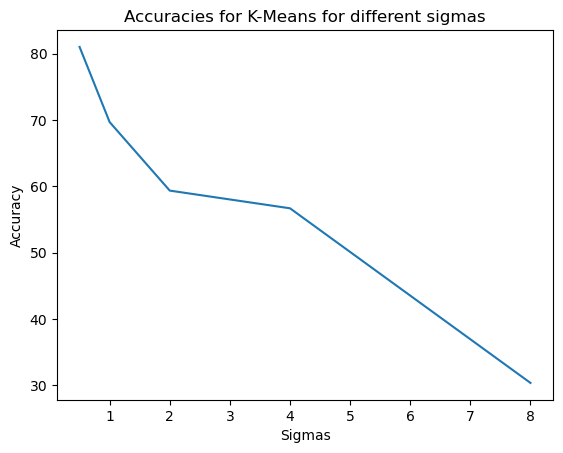

In [439]:
plt.plot(sigmas,accs)
plt.title("Accuracies for K-Means for different sigmas")
plt.xlabel("Sigmas")
plt.ylabel("Accuracy")

Text(0, 0.5, 'Norm (Objective)')

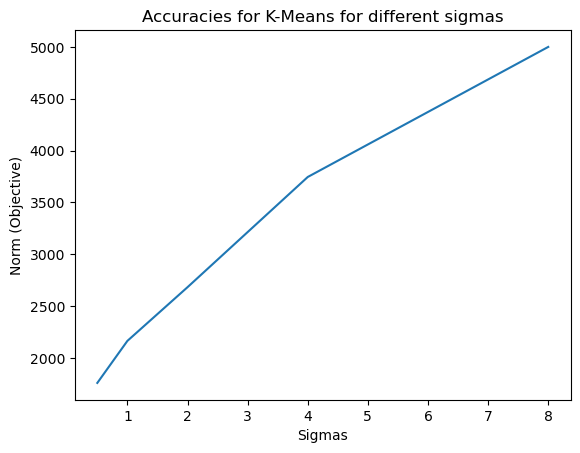

In [514]:
plt.plot(sigmas, objectives)
plt.title("Accuracies for K-Means for different sigmas")
plt.xlabel("Sigmas")
plt.ylabel("Norm (Objective)")

In [517]:
def random_cov_init(n):
    random_sq = np.random.rand(n,n)
    return np.dot(random_sq,random_sq.T)

def log_likelihood(data, mu, sigma, phi):
    log_likelihood = 0
    for i in range(data.shape[0]):
        likelihood = 0
        for j in range(len(mu)):
            component = multivariate_normal(mean=mu[j], cov=sigma[j])
            likelihood += phi[j] * component.pdf(data[i])
        log_likelihood += np.log(likelihood)
    return log_likelihood

def GMM(data, k, threshold = 0, max_iter = 500):
    m, n = data.shape
    mu = np.random.rand(k, n) * np.max(data, axis=0)
    # initiaizing as an identity matrix as this gave me the best results and no errors
    sigma = np.array([np.eye(n) for _ in range(k)])
    # sigma = np.array([random_cov_init(n) for _ in range(k)])
    phi = np.ones(k) / k # initializing all classes to have the same phi at the beginning
    diff_likelihood = None
    new_likelihood = 0
    iterations = 0
    while (diff_likelihood == None or diff_likelihood > threshold ) and iterations <= max_iter: 
        weights = np.zeros((m, k))
        for j in range(k):
            weights[:, j] = phi[j] * multivariate_normal.pdf(data, mean=mu[j], cov=sigma[j])
        # the total posterior porbability of each class is now stored in weights so we for the denominator, we can just sum the weights matrix
        denominator = weights.sum(axis=1, keepdims=True)
        # for each in denominator:
            # if np.isnan(each) == True:
                # print(np.isnan(each))
        weights = weights/denominator

        sum_weights = weights.sum(axis=0)
        phi = sum_weights / m
        # print(weights.shape, data.shape)
        mu = np.dot(weights.T, data) / sum_weights[:, np.newaxis]
        sigma = [np.dot(weights[:, j] * (data - mu[j]).T, (data - mu[j])) / sum_weights[j]
                      for j in range(k)]

        prev_likelihood  = new_likelihood
        new_likelihood = log_likelihood(data, mu, sigma, phi)
        diff_likelihood = np.abs(new_likelihood - prev_likelihood)
        
        iterations += 1
        
    return mu, sigma, phi, new_likelihood, iterations


In [507]:
data, labels  = create_dataset(means, covs, sigmas, 100)
k_gmm = 3
accs_gmm = []
objectives_gmm = []
for i in range(len(data)):

    pred_mu, pred_sigma, pred_phi, _ = GMM(data[i],k_gmm)
    updated_labels = new_labels(means, pred_mu, labels[i])
    mean_labels = []
    for point in data[i]:
        scores = [] 
        for k in range(k_gmm):
            scores.append(np.sqrt(np.sum(np.square(pred_mu[k] - point))))
        mean_labels.append(np.argmin(scores))
    acc = get_acc(mean_labels, updated_labels)
    accs_gmm.append(acc)
    objectives_gmm.append(objective)

In [527]:
objectives_gmm = [-1000, -1320, -1479, -1650, -2200]

Text(0, 0.5, 'Accuracy')

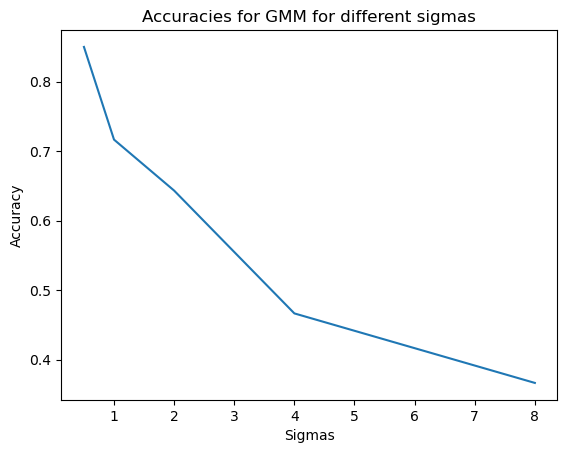

In [522]:
plt.plot(sigmas,accs_gmm)
plt.title("Accuracies for GMM for different sigmas")
plt.xlabel("Sigmas")
plt.ylabel("Accuracy")

Text(0, 0.5, 'Norm (Objective)')

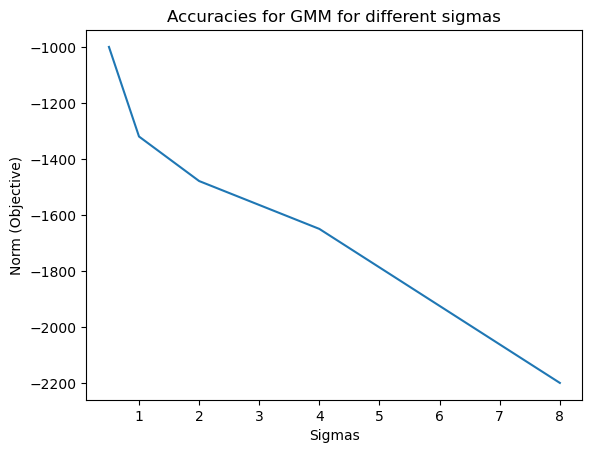

In [528]:
plt.plot(sigmas, objectives_gmm)
plt.title("Accuracies for GMM for different sigmas")
plt.xlabel("Sigmas")
plt.ylabel("Norm (Objective)")

# PCA and DRO
## All the PCAs:

In [331]:
filename = 'data\\data2D.csv'
arr = np.loadtxt(filename,delimiter=',')


def buggyPCA(arr, d):
    U, S, VT = np.linalg.svd(arr, full_matrices=0)
    V = VT.T
    projs = np.dot((arr @  V[:, :d]),  V[:, :d].T)
    return [U,S,VT] , _ , projs

def demeanedPCA(arr, d):
    mean_centred = arr - np.mean(arr, axis=0)
    U, S, VT = np.linalg.svd(mean_centred, full_matrices=0)
    V = VT.T
    projs = np.dot((mean_centred @  V[:, :d]),  V[:, :d].T)+  np.mean(arr, axis=0)
    return [U,S,VT] , np.mean(arr, axis=0), projs

def normalizedPCA(arr, d):
    mean = np.mean(arr, axis=0)
    std = np.std(arr, axis=0)
    scaled_data = (arr-mean)/std
    U, S, VT = np.linalg.svd(scaled_data, full_matrices=0)
    V = VT.T
    projs = np.dot((scaled_data @  V[:, :d]),  V[:, :d].T) * std + mean
    return [U,S,VT] , [mean, std], projs



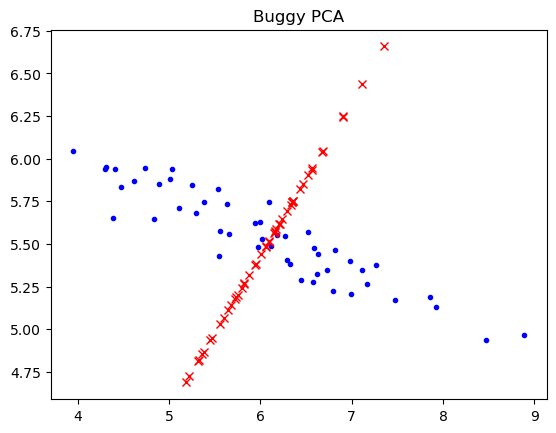

Reconstruction Error: 0.8869030837347942


In [315]:
    
_, _ , buggy_rec = buggyPCA(arr, 1)
    
plt.plot(arr[:,0], arr[:,1], '.', c = 'b')
plt.plot(buggy_rec[:,0], buggy_rec[:,1], 'x', c = 'red')
plt.title("Buggy PCA")
plt.show()
print("Reconstruction Error:", np.sum(np.square(arr - buggy_rec)) / arr.shape[0])


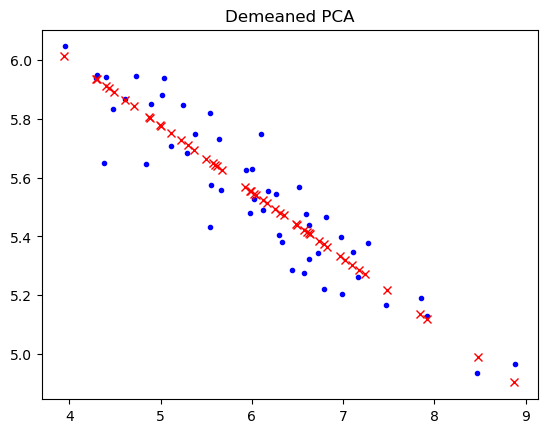

Reconstruction Error: 0.010006085628512917


In [524]:
    
_, _ , demeaned = demeanedPCA(arr, 1)
    
plt.plot(arr[:,0], arr[:,1], '.', c = 'b')
plt.plot(demeaned[:,0], demeaned[:,1], 'x', c = 'red')
plt.title("Demeaned PCA")
plt.show()
print("Reconstruction Error:", np.sum(np.square(arr - demeaned)) / arr.shape[0])


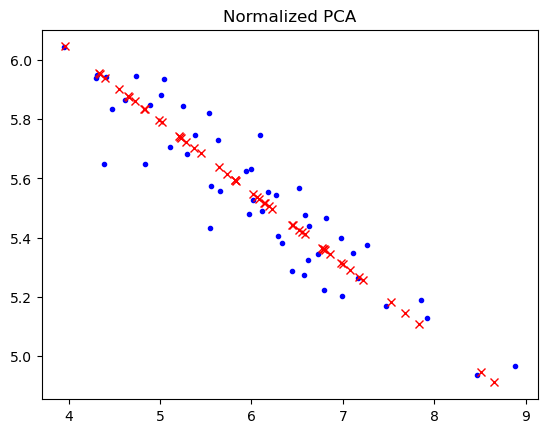

Reconstruction Error: 0.049472083454770714


In [320]:
    
_, _ , norm_PCA = normalizedPCA(arr, 1)
    
plt.plot(arr[:,0], arr[:,1], '.', c = 'b')
plt.plot(norm_PCA[:,0], norm_PCA[:,1], 'x', c = 'red')
plt.title("Normalized PCA")
plt.show()
print("Reconstruction Error:", np.sum(np.square(arr - norm_PCA)) / arr.shape[0])


In [326]:
def DRO(X, d):
    n = X.shape[0]
    b = np.mean(X, axis=0)
    U, S, VT = np.linalg.svd(X - b, full_matrices=False)
    Ud = U[:, :d]
    Sd = np.diag(S[:d])
    Vd = VT[:d, :]
    A = np.transpose(1/np.sqrt(n) * Sd @ Vd)
    Z = np.sqrt(n) * Ud
    Y = Z @ A.T +b
    
    return [U,S,VT], [A,Z,b], Y

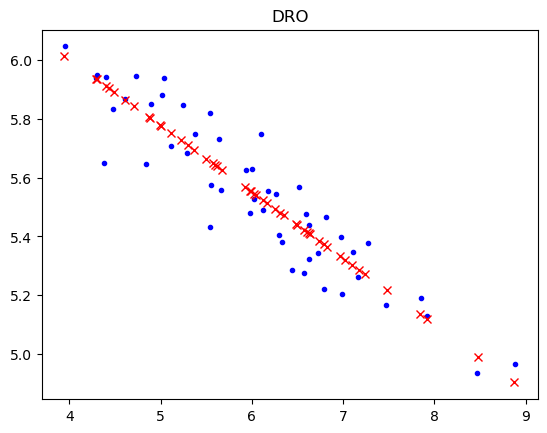

Reconstruction Error: 0.010006085628512922


In [327]:
_, _ , dro_vals = DRO(arr, 1)
    
plt.plot(arr[:,0], arr[:,1], '.', c = 'b')
plt.plot(dro_vals[:,0], dro_vals[:,1], 'x', c = 'red')
plt.title("DRO")
plt.show()
print("Reconstruction Error:", np.sum(np.square(arr - dro_vals)) / arr.shape[0])


array([737.31190921, 725.31727282, 703.71435255, 689.22314877,
       685.70740528, 681.0734858 , 670.6490996 , 660.40414309,
       651.84280526, 641.34969726, 632.37312193, 613.86440729,
       605.86803322, 593.57132199, 578.34722842, 571.36873052,
       562.88654934, 557.5354287 , 541.10084128, 514.78601313,
        28.72590083,  28.51207387,  28.19595079,  28.0560462 ,
        27.99914101,  27.78243982,  27.7017621 ,  27.52869482,
        27.49365939,  27.44015712])

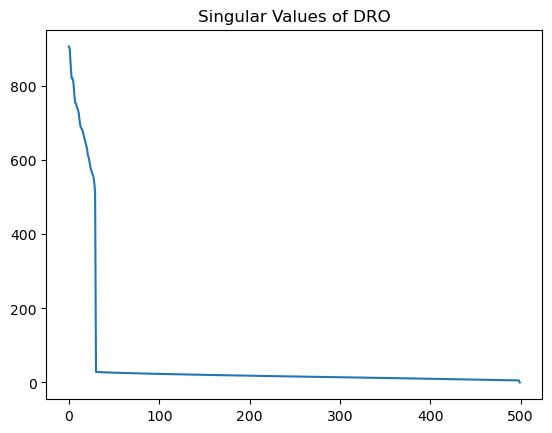

In [341]:
filename = 'data\\data1000d.csv'
arr_1kd = np.loadtxt(filename,delimiter=',')
arr_1kd.shape
svd, _ , dro_vals = DRO(arr_1kd, arr_1kd.shape[-1])
s = svd[1]
plt.plot(s)
plt.title("Singular Values of DRO")
s[10:40]
